## NOTES:
<ul>
<li>Sections labeled <strong>CORE</strong> must be run in order to begin Aquifer Analysis</li>
<li>Cells labeled <strong>Control</strong> contain inputs for the immeadiately proceeding section(s)</li>
<li>Sections labeled <strong>EXTRA</strong> contain additional plotting or analysis tools but are not necessary for Aquifer Analysis</li>
</ul>

## CORE: Imports

In [3]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but should be understood
pd.options.mode.chained_assignment = None

#pd.options.mode.chained_assignment = 'warn'

## CORE: Single Site Data<br>
This function produces the streamflow analysis (using the functions above) for a single site given a list of thresholds and time windows to analyze

Controls:

In [4]:
import Src.classes as cl
import Src.func as fn
reload(cl)

# df2 holds all-time data, df is analyzed range
curr_guage = cl.SRB_Guage
df = nwis.get_record(sites=curr_guage.id, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=curr_guage.post_start_date, end=fn.DEFAULT_END)
df2 = nwis.get_record(sites=curr_guage.id, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=curr_guage.mean_start_date, end='2015-04-28')

# Set to true if running indepedently to verify data with Kocis paper (or other source)
# Set to false if running Aquifer Analysis
testing = False

Single Site Analysis:

In [39]:
# If looking at a post impairment period, but calculating threshold based on the full record of data, pass a second dataframe with a different 
# start/end date as the final parameter. This method was used in Kocis 2017 and is needed for some data verification, but is not the methodology
# used for the Aquifer Analysis and so *args will most often be empty.
import Src.func as fn
reload(fn)

def single_site_data(df: pd.DataFrame, quantiles_list: list, data_ranges_list: list, *args):
    df = df.reset_index()    
    threshold = None
    df_complete_site_data = pd.DataFrame()    
    df_complete_mk_mag = pd.DataFrame()
    df_complete_mk_dur = pd.DataFrame()
    df_complete_mk_intra = pd.DataFrame()
    
    for data_range in data_ranges_list:
        for quantile in quantiles_list:
            # Copying original dataframe to avoid any conflicts
            df_copy = df.copy()
            
            # Validate that site is not missing > 10% of data
            date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
            missing = fn.validate(df, date_threshold, fn.DEFAULT_END)
            valid = missing < fn.MAX_MISSING_THRESHOLD   
            
            # Filter dataframe based on current data_range (don't do this during testing if testing unique dataset/range)
            if not testing:
                df_copy = df_copy[df_copy['datetime'].dt.date >= date_threshold]                              
    
            # Check for optional second dataframe containing full record
            if args and isinstance(args[0], pd.DataFrame) and not args[0].empty:
                #print('Threshold calculation across the full record')
                df2 = args[0].reset_index()
                threshold = fn.calc_threshold(df2, quantile) 
            else:
                #print('Threshold calculation across a limited record')
                threshold = fn.calc_threshold(df_copy, quantile)
                #threshold = 52350 # SRB_Guage post-impairment threshold for verification with Kocis_2017             

            # Create a dataframe with only days over HMF threshold as well as zero-deflated dataframe for MK trend test
            hmf_series, zero_deflated_hmf = fn.filter_hmf(df_copy, threshold)
            #print(zero_deflated_hmf)
            
            # Aggregate data before performing MK, set no-HMF years to 0
            agg_series = pd.DataFrame(zero_deflated_hmf)
            agg_series.set_index('datetime', inplace=True)
            agg_series = agg_series.resample(fn.HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
            agg_series.columns = ['Sum', 'Count']
            #agg_series = agg_series[agg_series['Sum'] > 0]
            #agg_series.to_csv('agg_series.csv')
            
            # MK Magnitude
            mk_result_mag = ('NA',) * 9
            mk_result_mag = fn.mann_kendall(fn.convert_cubic_ft_hm(agg_series['Sum']), fn.MK_TREND_ALPHA)
            #print(mk_result.trend, mk_result.slope)

            # Find number of years with HMF (10 for October 1st)
            hmf_years = fn.num_hmf_years(hmf_series, 10)    

            # Mask out months that don't fall within 3 and 6 month Winter range
            df_six_month, df_three_month = fn.three_six_range(hmf_series, 12, 2, 11, 4)

            # Convert to daily average flow in cfps, and take only flow above the threshold
            hmf_series = fn.convert_hmf(hmf_series, threshold)
            total_hmf_flow = hmf_series["00060_Mean"].sum()
            hmf_per_month = fn.monthly_hmf(hmf_series, data_range, quantile)
            #monthly_hmf(hmf_series, threshold)
            #print(f'Total Volume of HMF: {total_hmf_flow}')

            # Calculate 3 and 6 month HMF
            df_six_month = fn.convert_hmf(df_six_month, threshold)
            six_month_hmf = df_six_month["00060_Mean"].sum()
            df_three_month = fn.convert_hmf(df_three_month, threshold)
            three_month_hmf = df_three_month["00060_Mean"].sum()
            
            total_hmf_flow = (total_hmf_flow * fn.CUBIC_FT_KM_FACTOR) / hmf_years
            six_month_hmf = (six_month_hmf * fn.CUBIC_FT_KM_FACTOR) / hmf_years
            three_month_hmf = (three_month_hmf * fn.CUBIC_FT_KM_FACTOR) / hmf_years

            # Inter-annual
            hmf_series_full, _ = fn.filter_hmf(df_copy, threshold)
            hmf_years_full = fn.num_hmf_years(hmf_series_full, 10)

            delta = df_copy['datetime'].max().year - df_copy['datetime'].min().year
            inter_annual = (hmf_years_full / delta) * 100

            # Average Duration
            avg_duration, df_dur_mk = fn.calc_duration(hmf_series, hmf_years)
            mk_result_dur = ('NA',) * 9
            mk_result_dur = fn.mann_kendall(df_dur_mk, fn.MK_TREND_ALPHA)
                        
            # Intra-annual Frequency (avg. flow events per year)
            intra_annual, df_intra_mk = fn.calc_intra_annual(hmf_series, hmf_years)
            mk_result_intra = ('NA',) * 9
            mk_result_intra = fn.mann_kendall(df_intra_mk['hmf_events'], fn.MK_TREND_ALPHA)            

            # TODO: One-day peaks (avg. # of times hmf occurs on one day only)
            
            # Timing Calculation using DOHY
            center_of_mass = fn.calc_center_of_mass(hmf_series)
            
            # Merging site dataframe with Mann-Kendall dataframe. This start date is the beginning of the actual data, not necessarily 
            # the beginning of the analyzed range. Validation (above) starts from the start of the official range (1970/90-2020)
            start = df_copy['datetime'].min().date()
            end = df_copy['datetime'].max().date()
            data = {'dataset_ID': (data_range * quantile), 'site_no': df_copy.iloc[0]['site_no'], 'analyze_start': start, 'analyze_end': end, 'analyze_range': delta, 'quantile': quantile, 
                    'valid': valid, 'threshold': threshold, 'hmf_years': hmf_years, 'annual_hmf': total_hmf_flow, 'six_mo_hmf': six_month_hmf, 'three_mo_hmf': three_month_hmf, 
                    'duration': avg_duration, 'inter_annual': inter_annual, 'intra_annual': intra_annual, 'CoM': center_of_mass}              
            
            # Merging MK magnitiude
            df_mk_mag = pd.DataFrame([mk_result_mag], columns=['mk_trend', 'mk_h', 'mk_p', 'mk_z', 'mk_tau', 'mk_s', 'mk_var_s', 'mk_slope', 'mk_int'], index=['0'])
            df_mk_mag.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_mag.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_mag = pd.concat([df_complete_mk_mag.reset_index(drop=True), df_mk_mag.reset_index(drop=True)], axis=0) 
            
            # Merging MK duration
            df_mk_dur = pd.DataFrame([mk_result_dur], columns=['mk_trend', 'mk_h', 'mk_p', 'mk_z', 'mk_tau', 'mk_s', 'mk_var_s', 'mk_slope', 'mk_int'], index=['0'])
            df_mk_dur.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_dur.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_dur = pd.concat([df_complete_mk_dur.reset_index(drop=True), df_mk_dur.reset_index(drop=True)], axis=0)   
            
            # Merging MK intra-annual
            df_mk_intra = pd.DataFrame([mk_result_intra], columns=['mk_trend', 'mk_h', 'mk_p', 'mk_z', 'mk_tau', 'mk_s', 'mk_var_s', 'mk_slope', 'mk_int'], index=['0'])
            df_mk_intra.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_intra.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_intra = pd.concat([df_complete_mk_intra.reset_index(drop=True), df_mk_intra.reset_index(drop=True)], axis=0)        
            
            # Merging metric results
            df_single_iteration = pd.DataFrame(data, index=['0'])
            df_single_iteration = pd.concat([df_single_iteration.reset_index(drop=True), hmf_per_month.reset_index(drop=True)], axis=1)
            df_complete_site_data = pd.concat([df_complete_site_data.reset_index(drop=True), df_single_iteration.reset_index(drop=True)], axis=0)
        
    # TODO: Change this to return a list of dataframes rather than individual dataframes
    return df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra

# For testing purposes, to run this cell independently
df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra = single_site_data(df, fn.QUANTILE_LIST, fn.DATA_RANGE_LIST)

try:
    with pd.ExcelWriter('df_single_site.xlsx') as writer:
        df_complete_site_data.to_excel(writer, sheet_name='site_metrics', index=False)
        df_complete_mk_mag.to_excel(writer, sheet_name='mk_magnitude', index=False)
        df_complete_mk_intra.to_excel(writer, sheet_name='mk_intra', index=False)
        df_complete_mk_dur.to_excel(writer, sheet_name='mk_duration', index=False)
except Exception as e:
    print(e)
    
#fn.single_site_report(df_complete_site_data, df_complete_mk_mag)
#fn.save_data(df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra, 'TEST')


## CORE: Multi-Site Filtering<br>
This function creates the list of sites to analyze by filtering the complete list of state sites with 00060_Mean data down to those that lie within a specific watershed boundary using decimal long/lat positional data and a region shapefile (e.g. state or watershed boundary)<br><br>

Controls:

In [40]:
# This is only needed when running the following cell independently
shapefile_path = f'ShapeFiles/CA/Central/South_Central/WBDHU4.shp'

Site List Generation:

In [41]:
def filter_state_site(shapefile_path: str, state_uri: str):
    """Creates a list of sites with over 50 years of 00060_Mean streamflow data for a given region"""
    # Request page from USGS site, ignore all informational lines
    response = requests.get(state_uri)
    data = response.text
    lines = data.splitlines()
    lines = [line for line in lines if not line.startswith('#')]

    # Create dataframe where site_no is a list of all sites in a state with 00060 data
    tsd = "\n".join(lines)
    df = pd.read_csv(StringIO(tsd), sep='\t')
    df_state_sites = df.iloc[1:]
        
    # Filter out sites outside of HU boundary
    if fn.SORT_BY_WB:
        shapefile = gpd.read_file(shapefile_path)
        df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
        gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
        df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')
            
    #print(df_state_sites.columns.to_list())
    #print(df_state_sites)
    
    return df_state_sites

df_state_sites = filter_state_site(shapefile_path, fn.SITES_URI)
print(f'Total Sites: {len(df_state_sites)} in the state of {fn.STATE_CODE.upper()} in the given WB')
site_list = df_state_sites['site_no'].to_list()
print(site_list)

Total Sites: 53 in the state of CA in the given WB
['11224000', '11251000', '11255575', '11261100', '11261500', '11262900', '11264500', '11266500', '11273400', '11274000', '11274500', '11274550', '11274630', '11274790', '11276500', '11276600', '11276900', '11277300', '11278000', '11278300', '11278400', '11284400', '11289000', '11289500', '11289650', '11289850', '11290000', '11299600', '11303000', '11303500', '11304810', '11311300', '11312672', '11312676', '11312685', '11312968', '11313240', '11313315', '11313405', '11313431', '11313433', '11313434', '11313440', '11313452', '11313460', '11335000', '11336600', '11336790', '11336930', '11336955', '11337190', '11447903', '375450121331701']


## CORE: Multi-Site Data Creation<br>
This function uses the list generated by the previous section to generate single site data for every site in the list, and validate that no site is missing more than 10% of its data

In [43]:
# REQUIRES: 'df_state_sites' from 'Multi-Site Filtering'
# Used for now to limit runtime when running independently
site_limit = 3

def create_multi_site_data(df_state_sites: pd.DataFrame, site_limit: int):
	"""Generates detailed HMF, MK, and POS information for each site in the passed dataframe"""
	# Necessary for proper iterrows() behavior
	df_state_sites.reset_index(drop=True, inplace=True)

	# Creating the dataframe that will hold final results for mapping
	df_multi_site_metric = pd.DataFrame()
	df_multi_site_mk_mag = pd.DataFrame()
	df_multi_site_mk_dur = pd.DataFrame()
	df_multi_site_mk_intra = pd.DataFrame()

	for index, row in df_state_sites.iterrows():
		while index < site_limit:
			# Create a dataframe for the current site in the iteration to perform calculations on
			df = nwis.get_record(sites=row['site_no'], service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
			df = df.reset_index()
			
			# Confirm that dataframe is not empty and has the required streamflow data before continuing
			if df.empty:
				print(f'ERROR: No data for site {row["site_no"]}')
				break
			if '00060_Mean' not in df.columns:
				print(f'ERROR: No 00060_Mean data for site {row["site_no"]}')
				break
			
			# Filter out sites with less than the minimum required range of data
			start = df['datetime'].min().date()
			end = df['datetime'].max().date()
			range = round((end - start).days / 365.25, 1)
			
			# Ignore sites with less than the minimum required years of data
			if range < fn.MIN_DATA_PERIOD:
				print(f'ERROR: Not enough data for site {row["site_no"]}')
				break			
				
			df_single_site_metric, df_mk_mag, df_mk_dur, df_mk_intra = single_site_data(df, fn.QUANTILE_LIST, fn.DATA_RANGE_LIST)			
			
			# Append positional data to dataframe created by single_site_data()
			add_data = {'dec_lat_va': row['dec_lat_va'], 'dec_long_va': row['dec_long_va'], 'data_start': start, 'data_end': end, 'total_record': range}			
			add_data = pd.DataFrame(add_data, index=['0'])
   
			# Duplicates the rows of add_data so that positional information is passed to each individual dataframe when this frame is split
			add_data = pd.DataFrame(np.tile(add_data.values, (len(df_single_site_metric), 1)), columns=add_data.columns)
			df_single_site_metric = pd.concat([df_single_site_metric.reset_index(drop=True), add_data.reset_index(drop=True)], axis=1)

			# Append single site data to multi-site dataframes
			df_multi_site_metric = pd.concat([df_multi_site_metric, df_single_site_metric], ignore_index=True)
			df_multi_site_mk_mag = pd.concat([df_multi_site_mk_mag, df_mk_mag], ignore_index=True)
			df_multi_site_mk_dur = pd.concat([df_multi_site_mk_dur, df_mk_dur], ignore_index=True)
			df_multi_site_mk_intra = pd.concat([df_multi_site_mk_intra, df_mk_intra], ignore_index=True)   
   		
			print(f'Added site {index + 1} of {len(df_state_sites)}')
			
			#clear_output(wait=True)
			#time.sleep(0.500)
			break

	return df_multi_site_metric, df_multi_site_mk_mag, df_multi_site_mk_dur, df_multi_site_mk_intra

df_multi_site_metric, df_multi_site_mk_mag, df_multi_site_mk_dur, df_multi_site_mk_intra = create_multi_site_data(df_state_sites, site_limit)
df_multi_site, df_invalid_site = fn.filter_by_valid(df_multi_site_metric)
#df_multi_site.to_csv('df_multi_site.csv')
#print(df_multi_site)

print(f'Max HMF for this region: {df_multi_site["annual_hmf"].max():.1f}')
print(f'{len(df_multi_site)} site(s) valid out of {len(df_multi_site_metric)}')

ERROR: Not enough data for site 11224000
Added site 2 of 53
ERROR: Not enough data for site 11255575
Max HMF for this region: 0.7
4 site(s) valid out of 4


## CORE: Aquifer Analysis
This section generates aquifer-wide data based on all watershed boundary shapefiles that intersect with the aquifer boundary. In addition it contains a section to generate a map of this aquifer boundary, the intersecting watershed boundaries, and their relevant water gauge sites and annual high magnitude flows<br><br>
Aquifer Analysis Controls:

In [44]:
# Set the aquifer to collect data for
curr_aquifer = cl.upper_clairborne_aquifer

# Limit analyzed sites for testing purposes
# Set to >999 to analyze all sites
site_limit = 10

Data Creation: 
<li>This code is time-consuming and can be bypassed if a spreadsheet for an aquifer already exists and all that is desired is a plot based on that data</li>

In [45]:
# Data Creation
df_aq_sites_metric = pd.DataFrame()
df_aq_sites_mk_mag = pd.DataFrame()
df_aq_sites_mk_dur = pd.DataFrame()
df_aq_sites_mk_intra = pd.DataFrame()

for root, dirs, files in os.walk(curr_aquifer.wb_dir):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if curr_aquifer.wb_shapefiles in files:
            shapefile_aq_path = os.path.join(root, curr_aquifer.wb_shapefiles)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)           
            print("Path: ", shapefile_aq_path)
            
            for state_code in curr_aquifer.states:
                print("Trying: ", state_code)
                try:
                    state_uri = fn.create_state_uri(state_code, fn.PARAM_CODE)
                    df_state_sites = filter_state_site(shapefile_aq_path, state_uri)
                    df_temp_metric, df_temp_mk_mag, df_temp_mk_dur, df_temp_mk_intra = create_multi_site_data(df_state_sites, site_limit)
                    df_temp_metric['State'] = state_code
                    df_aq_sites_metric = pd.concat([df_aq_sites_metric, df_temp_metric], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_mag = pd.concat([df_aq_sites_mk_mag, df_temp_mk_mag], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_dur = pd.concat([df_aq_sites_mk_dur, df_temp_mk_dur], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_intra = pd.concat([df_aq_sites_mk_intra, df_temp_mk_intra], axis=0, ignore_index=True).reset_index(drop=True)
                except Exception as e:
                    print("ERROR: ", e)
                    print(state_uri)
                    continue

# Filtering out invalid sites by data range and duplicates as some sites are listed in 2+ states   
# Also adds a column to indicate presence in HCDN-2009
#df_aq_sites = df_aq_sites.drop_duplicates(subset=['site_no'])
df_aq_sites_metric = fn.gages_2_filtering(df_aq_sites_metric)
#df_aq_sites_metric.to_csv(f'{curr_aquifer.name}_Raw.csv') 
#df_aq_sites, _ = filter_by_valid(df_aq_sites)

fn.save_data(df_aq_sites_metric, df_aq_sites_mk_mag, df_aq_sites_mk_dur, df_aq_sites_mk_intra, curr_aquifer.name)  
#print(df_aq_sites)

Path:  ShapeFiles/Aquifers/Upper_Clairborne_MS/HUC4\NHD_H_0316\WBDHU4.shp
Trying:  AR
Trying:  LA
Trying:  MS
ERROR: No data for site 02430005
ERROR: Not enough data for site 02430085
ERROR: No data for site 02430161
ERROR: No data for site 02430626
ERROR: Not enough data for site 02430680
ERROR: Not enough data for site 02430880
Added site 7 of 21
ERROR: No data for site 02431011
ERROR: Not enough data for site 02432500
ERROR: No data for site 02433151
Trying:  TN
Trying:  KY
Trying:  MO
Trying:  AL
ERROR: Not enough data for site 02378300
Added site 2 of 54
ERROR: No data for site 0237854520
ERROR: Not enough data for site 02378780
Added site 5 of 54
Added site 6 of 54
ERROR: Not enough data for site 02444160
Added site 8 of 54
ERROR: Not enough data for site 02447025
Added site 10 of 54
Path:  ShapeFiles/Aquifers/Upper_Clairborne_MS/HUC4\NHD_H_0317\WBDHU4.shp
Trying:  AR
Trying:  LA
Trying:  MS
Added site 1 of 25
Added site 2 of 25
ERROR: Not enough data for site 02472850
ERROR: Not

Plot Generation Controls:

In [42]:
# The dataset (spreadsheet from Aquifer Analysis) to be plotted
dataset = 'Upper_Clairborne_30_90.csv'
datapath = f'Prelim_Data/{dataset}'

# Only set to true if you want to save and overwrite a new image of the current dataset
overwrite = False

Aquifer Plot Generation:

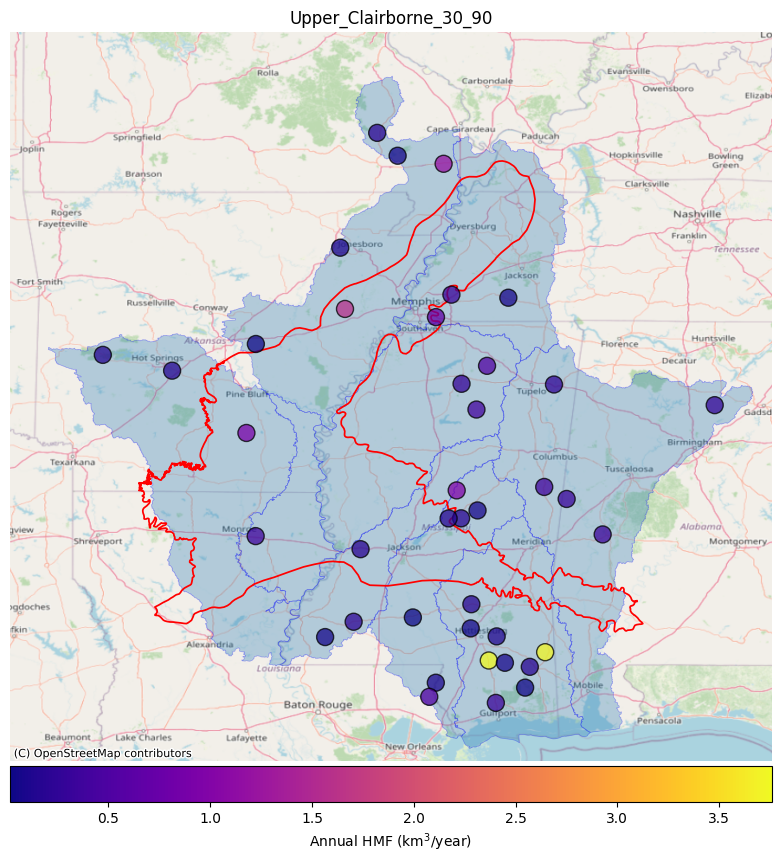

In [43]:
# REQUIRES: df_aq_sites either from Data Creation or multi_site.csv
fig, ax = plt.subplots(figsize=(10, 10))
plt.title(dataset[:-4], loc='center')

if os.path.exists(datapath):
    df_aq_sites = pd.read_csv(datapath)
    df_aq_sites, _ = fn.filter_by_valid(df_aq_sites)

# HUC4 Region Plot
for root, dirs, files in os.walk(curr_aquifer.wb_dir):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if curr_aquifer.wb_shapefiles in files:
            shapefile_aq_path = os.path.join(root, curr_aquifer.wb_shapefiles)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)
            ws_gdf.plot(ax=ax, edgecolor='blue', alpha=0.30, linewidth=0.5)

# Aquifer boundary plot
aq_gdf = gpd.read_file(curr_aquifer.aq_shapefile)
aq_gdf = aq_gdf.to_crs(4269)

xmin, ymin, xmax, ymax = aq_gdf.total_bounds
padding = 1.5
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

aq_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.25)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Datapoints plot
lat = df_aq_sites['dec_lat_va'].tolist()
long = df_aq_sites['dec_long_va'].tolist()
geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geometry)

# Set colorbar limits and theme using undivided dataset so that scale is static
vmin = None
vmax = None
if os.path.exists(f'Prelim_Data/{curr_aquifer.name}_Raw.csv'):
    df_temp = pd.read_csv(f'Prelim_Data/{curr_aquifer.name}_Raw.csv')
    df_temp, _ = fn.filter_by_valid(df_temp)
    vmin = df_temp['annual_hmf'].min()
    vmax = df_temp['annual_hmf'].max()
else:
    vmin = df_aq_sites['annual_hmf'].min()
    vmax = df_aq_sites['annual_hmf'].max()
    
norm = mcolors.Normalize(vmin, vmax)
cmap = 'plasma'
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(df_aq_sites['annual_hmf'])

div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.05)

bx = geo_df.plot(ax=ax, column=df_aq_sites['annual_hmf'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
cbx = plt.colorbar(mappable, cax=cax, pad=0.05, aspect=25, orientation='horizontal', alpha=1.0)
cbx.set_label('Annual HMF ($\mathregular{km^3}$/year)')

ax.margins(0, tight=True)
ax.set_axis_off()
cx.add_basemap(ax, crs=aq_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=7)

img_str = f'Saved_Visuals/{dataset[:-4]}.png'
if os.path.exists(img_str) and overwrite:
    plt.savefig(f'Saved_Visuals/{dataset[:-4]}.png')
elif not os.path.exists(img_str):
    plt.savefig(f'Saved_Visuals/{dataset[:-4]}.png')
    

## EXTRA: Monthly HMF Frequency per Aquifer Plot
This plot shows the average number of times sites experienced HMF, broken down by month, across an aquifer region

In [44]:
hist_data_set = 'mfreq_cv_30_90.csv'
hist_data_path = f'C:/Users/alekh/Desktop/monthly_freq/{hist_data_set}'
number_of_sites = 81 # Hardcoded for Central_Valley_30_90

df_freq = pd.read_csv(hist_data_path)
df_freq = df_freq.sort_values('month')
df_freq = df_freq.drop(columns='Unnamed: 0')
df_freq = df_freq.reset_index(drop=True)
df_freq = df_freq.fillna(0)
df_freq['count'] = df_freq['count'] / number_of_sites

C:\Users\alekh\AppData\Local\Temp\ipykernel_82428\365415943.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, ax=None)


Text(0, 0.5, 'Times Month Saw HMF')

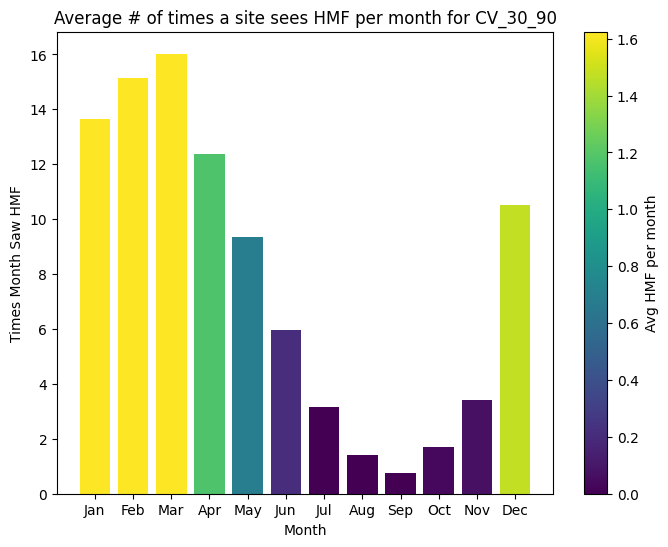

In [45]:
plt.figure(figsize=(8, 6))
plt.xticks(df_freq['month'], [calendar.month_name[int(m)][:3] for m in df_freq['month']], rotation=0)

vmin = df_freq['00060_Mean'].min()
vmax = df_freq['00060_Mean'].max()
norm = mcolors.Normalize(vmin, vmax)
cmap = 'viridis'
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(df_freq['00060_Mean'])

bars = plt.bar(df_freq['month'], df_freq['count'], color=plt.cm.viridis(df_freq['00060_Mean']))
cbar = plt.colorbar(mappable, ax=None)
cbar.set_label('Avg HMF per month')
plt.title('Average # of times a site sees HMF per month for CV_30_90')
plt.xlabel('Month')
plt.ylabel('Times Month Saw HMF')
plt.show()

## EXTRA: Single Region Map Creation<br>
This plots sites from 'df_multi_site' within a given region defined by a shapefile, but is not used in the overall Aquifer Analysis<br><br>
Controls:

In [ ]:
shapefile_path = f'ShapeFiles/OR/Whole_State/Shape/WBDHU4.shp'
shape = gpd.read_file(shapefile_path)
size_limit = 999

Region Plot Generation:

In [ ]:
def multi_site_map(df_multi_site: pd.DataFrame, shapefile_path=None):    
    #df = nwis.get_record(sites=SITE_NO, service='site')
    #df2 = nwis.get_record(sites='11303500', service='site')
    lat = df_multi_site['dec_lat_va'].tolist()
    long = df_multi_site['dec_long_va'].tolist()

    fig, ax = plt.subplots(figsize=(9, 9))
    ax.margins(0)

    # This plots the WB shapefile region if one is passed
    shape = gpd.read_file(shapefile_path)
    #print(shape.crs)
    shape.plot(ax=ax, alpha=0.50, edgecolor='black', linewidth=0.5)

    geometry = [Point(xy) for xy in zip(long, lat)]
    geo_df = gpd.GeoDataFrame(geometry=geometry)

    # Set colorbar limits and theme
    vmin = df_multi_site['hmf_per_year'].min()
    vmax = df_multi_site['hmf_per_year'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'plasma'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df_multi_site['hmf_per_year'])

    # This plots the datapoints
    bx = geo_df.plot(ax=ax, column=df_multi_site['hmf_per_year'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
    cbx = plt.colorbar(mappable, ax=bx, pad=0.01, aspect=25, orientation='horizontal', alpha=1.0)
    cbx.set_label('Annual HMF ($\mathregular{km^3}$/year)')

    #bx.set_title("WBDHU8")
    bx.margins(0, tight=True)
    bx.set_axis_off()

    # This plots the context backmap
    cx.add_basemap(bx, crs=shape.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)
    
df_state_sites = filter_state_site(shapefile_path)
df_multi_site = create_multi_site_data(df_state_sites, size_limit)
print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')
multi_site_map(df_multi_site, shape)

## EXTRA: Mann-Kendall Plot
This plots Mann-Kendall trend lines taken from a completed aquifer spreadsheet but is not used in the overall Aquifer Analysis<br><br>
Controls:

In [47]:
# Must be a 30-year date range dataset
mkdataset = 'Central_Valley_30_90.csv'
mkdatapath = f'Prelim_Data/{mkdataset}'

Mann-Kendall Plotting:

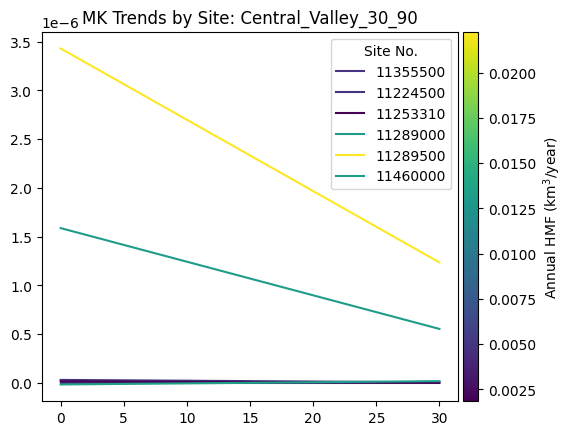

In [50]:
# REQUIRES: 'df_multi_site' from 'Gages-II Filter' OR a spreadsheet for testing
df = pd.read_csv(mkdatapath)
def create_mk_plot(df: pd.DataFrame):
    """Create a plot showing Mann-Kendall trends by site"""
    # Filter only sites that show a trend
    df.reset_index(drop=True, inplace=True)
    df = df[df['mk_h'] == True]

    fig, ax = plt.subplots()

    vmin = df['annual_hmf'].min()
    vmax = df['annual_hmf'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'viridis'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df['annual_hmf'])

    for _, row in df.iterrows():
        slope = row['mk_slope']
        intercept = row['mk_int']
        val = row['annual_hmf']
        
        x = np.linspace(0, 30)
        y = slope * x + intercept
        ax.plot(x, y, label=row['site_no'], color=mappable.to_rgba(val))
        
    ax.set_title(f'MK Trends by Site: {mkdataset[:-4]}')
    ax.legend(title='Site No.')
    #ax.axes.get_yaxis().set_ticks([])
    plt.colorbar(mappable, label='Annual HMF ($\mathregular{km^3}$/year)', ax=ax, pad=0.01, aspect=25, orientation='vertical', alpha=1.0)
    #ax.axhline(0, color='black', linewidth=1)
    #ax.axvline(0, color='black', linewidth=1)
    plt.show()

create_mk_plot(df)
